# Logistic and linear regression with deterministic and stochastic first order methods

    Lab 2 : Optimisation - DataScience Master
    Authors : Robert Gower, Alexandre Gramfort, Pierre Ablin, Mathurin Massias
   
The aim of this lab is to implement and compare various batch and stochastic algorithms for linear and logistic regression with ridge penalization. 

The following methods are compared in this notebook.

**Batch (deterministic) methods**

- gradient descent (GD)
- accelerated gradient descent (AGD)
- L-BFGS
- conjugate gradient (CG)

**Stochastic algorithms**

- stochastic gradient descent (SGD)
- stochastic averaged gradient (SAG)
- stochastic variance reduced gradient (SVRG)

Note that we consider as use-cases logistic and linear regression with ridge penalization only, although most of the algorithms below can be used with many other models, and other types of penalization, eventually non-smooth ones, such as the $\ell_1$ penalization.


## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 26th of november at 23:55**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "Mohamed-Rostom"
ln1 = "GHARBI"
fn2 = "Salma"
ln2 = "EL-BEZ"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab2", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab2_gharbi_mohamed-rostom_and_el-bez_salma.ipynb


In [2]:
## to embed figures in the notebook
%matplotlib inline
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### Table of content

[1. Loss functions, gradients and step-sizes](#loss)<br>
[2. Generate a dataset](#data)<br>
[3. Deterministic methods](#batch)<br>
[4. Stochastic methods](#stoc)<br>
[5. Numerical comparison](#comp)<br>
[6. Conclusion](#conc)<br>

In [3]:
%matplotlib inline

In [4]:
from time import time

import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt
from numba import njit
import warnings
warnings.filterwarnings('ignore')
import seaborn
seaborn.set()

In [5]:
# choose a large font size by default and use tex for math
usetex = False # change this to True if you have a working LaTeX install

fontsize = 16
params = {'axes.labelsize': fontsize + 2,
      'font.size': fontsize + 2,
      'legend.fontsize': fontsize + 2,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'text.usetex': usetex}
plt.rcParams.update(params)

<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes


We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2
$$
where
- $\ell(z, b) = \frac 12 (b - z)^2$ (least-squares regression)
- $\ell(z, b) = \log(1 + \exp(-bz))$ (logistic regression).

We write it as a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(x)
$$
where
$$
f_i(x) = \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2.
$$

For both cases, the gradients are
$$
\nabla f_i(x) = (a_i^\top x - b_i) a_i + \lambda x
$$
and
$$
\nabla f_i(x) = - \frac{b_i}{1 + \exp(b_i a_i^\top x)} a_i + \lambda x.
$$

Denote by $L$ (resp. $L_i$) the Lipschitz constant of $f$ (resp. $f_i$) and $\mathbf A^\top = [a_1, \ldots, a_n].$
One can easily see (using $\|\cdot\|_{2}$ for the matrix spectrale norm) that for linear regression
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{n} + \lambda \quad \text{ and } L_i = \| a_i \|_2^2 + \lambda
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{4 n} + \lambda \quad \text{ and } L_i = \frac 14 \| a_i \|_2^2 + \lambda.
$$
For full-gradient methods, the theoretical step-size is $1 / L$, while for SAG and SVRG (see below) it can be taken as
$1 / (\max_{i=1,\ldots,n} L_i)$

We now introduce functions that will be used for the solvers.


In [6]:
@njit    
def grad_i_linreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    return (a_i.dot(x) - b[i]) * a_i + lbda * x


@njit
def grad_linreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_linreg(i, x, A, b, lbda)
    return g / n


def loss_linreg(x, A, b, lbda):
    return norm(A.dot(x) - b) ** 2 / (2. * n) + lbda * norm(x) ** 2 / 2.


def lipschitz_linreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / n + lbda

In [7]:
@njit    
def grad_i_logreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    b_i = b[i]
    return - a_i * b_i / (1. + np.exp(b_i * np.dot(a_i, x))) + lbda * x


@njit
def grad_logreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_logreg(i, x, A, b, lbda)
    return g / n


def loss_logreg(x, A, b, lbda):
    bAx = b * np.dot(A, x)
    return np.mean(np.log(1. + np.exp(- bAx))) + lbda * norm(x) ** 2 / 2.


def lipschitz_logreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / (4. * n) + lbda


<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [8]:
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz


def simu_linreg(x, n, std=1., corr=0.5):
    """Simulation for the least-squares problem.

    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x) + noise
    return A, b

In [9]:
def simu_logreg(x, n, std=1., corr=0.5):
    """Simulation for the logistic regression problem.
    
    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size    
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """    
    A, b = simu_linreg(x, n, std=1., corr=corr)
    return A, np.sign(b)

In [10]:
d = 50
n = 10000
idx = np.arange(d)

# Ground truth coefficients of the model
x_model_truth = (-1)**idx * np.exp(-idx / 10.)

_A, _b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
#_A, _b = simu_logreg(x_model_truth, n, std=1., corr=0.7)

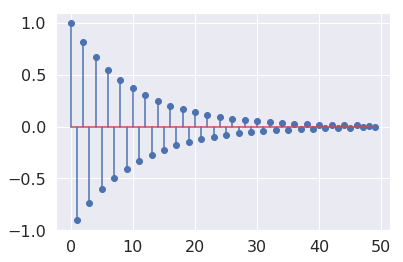

In [11]:
plt.stem(x_model_truth);

### Numerically check loss and gradient

In [12]:
from scipy.optimize import check_grad

lbda = 1. / n ** (0.5)

A, b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_linreg, grad_linreg, np.random.randn(d), A, b, lbda)

1.4199547931907486e-06

In [13]:
lbda = 1. / n ** (0.5)

A, b = simu_logreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_logreg, grad_logreg, np.random.randn(d), A, b, lbda)

1.9093142595157035e-07

### Choice of the model

In [14]:
A, b = simu_linreg(x_model_truth, n, std=1., corr=0.9)
loss = loss_linreg
grad = grad_linreg
grad_i = grad_i_linreg
lipschitz_constant = lipschitz_linreg
lbda = 1. / n ** (0.5)

### Compute the theoretical step-size for gradient descent

In [15]:
step = 1. / lipschitz_constant(A, b, lbda)

print("step = %s" % step)

step = 0.06237380858472054


### Get a very precise minimum to compute distances to minimum

In [16]:
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)

x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A, b, lbda), pgtol=1e-30, factr=1e-30)

print(f_min)
print(norm(grad_linreg(x_min, A, b, lbda)))

0.5145063614406438
2.5977337810136397e-08


<a id='batch'></a> 

## 3. Deterministic/Batch methods (GD, AGD, BFGS)

### Define a class to monitor iterations

In [17]:
class monitor:
    def __init__(self, algo, loss, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.loss = loss
        self.args = args
        self.f_min = loss(x_min, *args)
    
    def run(self, *algo_args, **algo_kwargs):
        t0 = time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time() - t0
        self.x_list = x_list
        self.err = [norm(x - self.x_min) for x in x_list]
        self.obj = [self.loss(x, *self.args) - self.f_min for x in x_list]

In [18]:
# Number of iterations
n_iter = 200

### Gradient descent (GD)

We recall that an iteration of batch gradient writes

$$
x_{k+1} \gets x_k - \eta \nabla f(x_k)
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the GD solver in the cell below

In [19]:
@njit
def gd(x_init, grad, n_iter=100, step=1., store_every=1, args=()):
    """Gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        
        ### TODO
        x=x-step*grad(x, *args)
        ### END TODO
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [20]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_gd = monitor(gd, loss, x_min, (A, b ,lbda))
monitor_gd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### Accelerated Gradient Descent (AGD)

We recall that an iteration of AGD (see FISTA) writes:

$$
\begin{align*}
x_{k+1} &\gets y_k - \eta \nabla f(y_k) \\
t_{k+1} &\gets \frac{1 + \sqrt{1 + 4 t_k^2}}{2} \\
y_{k+1} &\gets x_{k+1} + \frac{t_k-1}{t_{k+1}} (x_{k+1} - x_k)
\end{align*}
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the AGD solver in the cell below

In [21]:
@njit
def agd(x_init, grad, n_iter=100, step=1., args=(), store_every=1):
    """Accelerated Gradient Descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []
    for i in range(n_iter):
        if i % store_every == 0:
            x_list.append(x.copy())
        ### TODO
        x_new=(y-step*grad(y, args[0],args[1],args[2]))
        t_new=(1+np.sqrt(1+4*(t**2)))/2
        y=x_new+((t-1)*(x_new-x))/t_new
        
        x=x_new
        t=t_new
        ### END TODO
    return x, x_list

In [22]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_agd = monitor(agd, loss, x_min, (A, b ,lbda))
monitor_agd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### scipy.optimize's conjuguate gradient

Let's compare with ``scipy.optimize``'s nonlinear conjuguate gradient solver. First, define a function to run scipy algorithms and return the list of iterates.

In [23]:
class callback():
    def __init__(self):
        self.x_list = []
    
    def __call__(self, x):
        self.x_list.append(x.copy())
        
        
def scipy_runner(scipy_algo):
    def run(*args, **kwargs):
        cb = callback()
        x = scipy_algo(*args, **kwargs, callback=cb)
        return x, cb.x_list
    return run

In [24]:
# Nonlinear Conjugate gradient algorithm
from scipy.optimize import fmin_cg

x_init = np.zeros(d)

monitor_cg = monitor(scipy_runner(fmin_cg), loss, x_min, (A, b ,lbda))
monitor_cg.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), gtol=1e-9)

         Current function value: 0.514506
         Iterations: 146
         Function evaluations: 237
         Gradient evaluations: 236


### scipy.optimize's L-BFGS

Let's compare with ``scipy.optimize``'s L-BFGS solver

In [25]:
# L-BFGS algorithm
from scipy.optimize import fmin_l_bfgs_b


x_init = np.zeros(d)

monitor_bfgs = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min, (A, b ,lbda))
monitor_bfgs.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), pgtol=1e-30)

### A first numerical comparison of deterministic solvers

First, define some plotting functions.

In [26]:
def plot_epochs(monitors, solvers,show_lambda=False, lbda=0, show_corr=False, corr=0):
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    
    for monit in monitors:
        plt.semilogy(monit.obj, lw=2)
        
        if show_lambda:
            plt.title("$\lambda$ =" + str( lbda) + "        Loss",loc='left')  
            
        elif show_corr:
            plt.title("corr =" + str(corr) + "        Loss",loc='left')
            
        else:
            plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("objective")

    plt.legend(solvers,bbox_to_anchor=(0., -0.5, 1., .102), loc=8,
           ncol=4, mode="expand", borderaxespad=0.)

    plt.subplot(1, 2, 2)

    for monit in monitors:
        plt.semilogy(monit.err, lw=2)
        plt.title("Distance to optimum")
        plt.xlabel("Epoch")
        plt.ylabel("$\|x_k - x^*\|_2$")

    plt.legend(solvers,bbox_to_anchor=(0., -0.5, 1., .102), loc=8,
           ncol=4, mode="expand", borderaxespad=0.)
    

def plot_time(monitors, solvers):
    plt.figure(figsize=(15,7.5))
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers,bbox_to_anchor=(0., -0.5, 1., .102), loc=8,
           ncol=4, mode="expand", borderaxespad=0.)

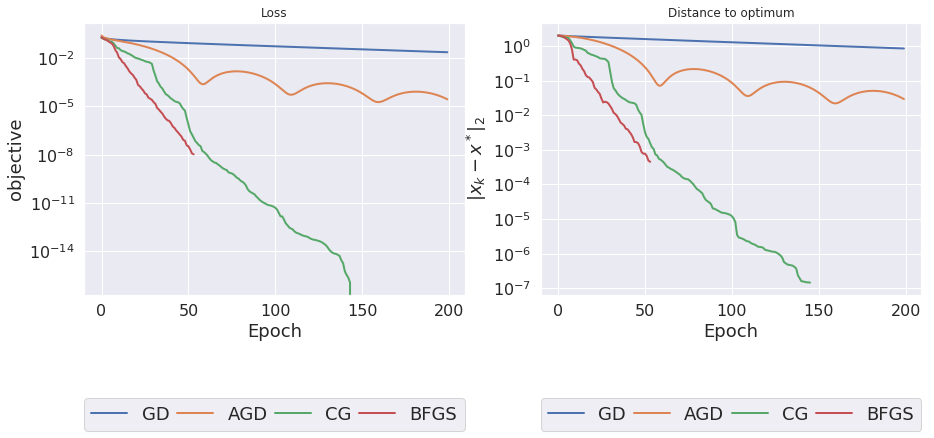

In [27]:
monitors = [monitor_gd, monitor_agd, monitor_cg, monitor_bfgs]

solvers = ["GD", "AGD", "CG", "BFGS"]

plot_epochs(monitors, solvers)

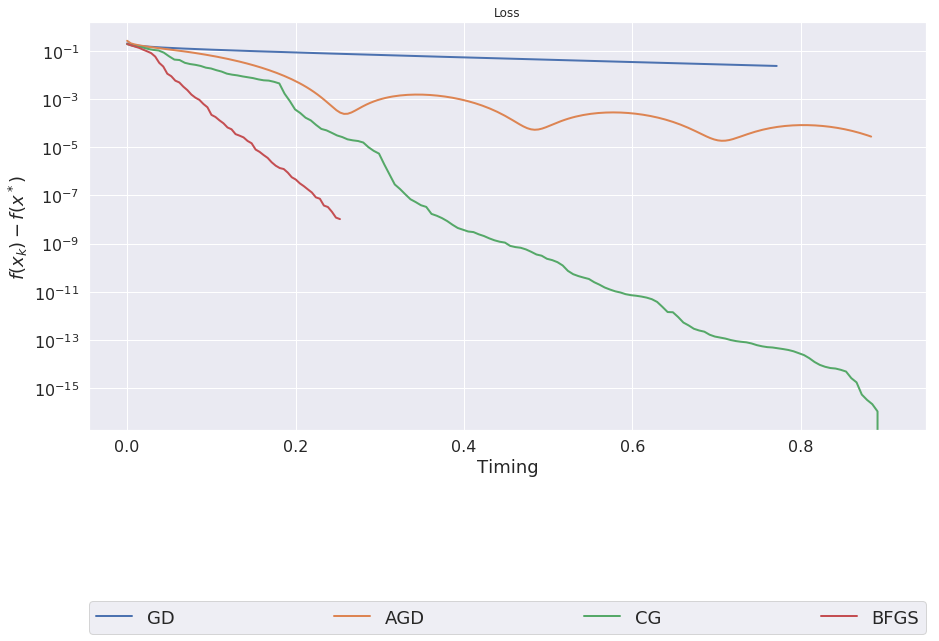

In [28]:
plot_time(monitors, solvers)

### First conclusions

*QUESTIONS*:

- Give some first conclusions about the batch solver studied here
- What do you observe about AGD? is it suprising ?

<div class="alert alert-danger">
    <center> <h2> Comments about the results above </h2> </center>
    </div>

<div class="alert alert-info">

<h4>- Give some first conclusions about the batch solver studied here</h4>

* GD : The clasic gradient descent algorithm. It is the slowest algorithm. We can see that it is linear in log-domain for strongly convex functions.
* AGD : The accelerated gradient descent algorithm. It is the 2nd slowest algorithm, and we can clearly see here that it does not converge monotonically. ( The explication will be for later ).
* CG : The the conjugate gradient method. We can see that this algorithm is performing quite well.
* BFGS : The Broyden–Fletcher–Goldfarb–Shanno algorithm is the best algorithm out of these 4. The only problem that is stops earlier. 

--------------------------------------------------------------

* We can clearly see that BFGS and CG are way better than both AGD and GD. On the other hand, we can observe that BFGS needs more iterations than CG to get to the minimum ( For the same amount of time, BFGS is at $ 10^{-8} $ wether CG is at $ 10^{-3} $). According to those graphs that we see above, BFGS is the fastest algorithm for batch solvers. 

</div>

<div class="alert alert-info">
<h4>- What do you observe about AGD? is it suprising ? </h4>

* What I observed about AGD, is that it is so similar to FISTA ( From Lab 1, part 3 ). It's curve oscilates like in FISTA's case. It is not a gradient descent algorithm like GD for example. It is explained by the fact that we compute at each iteration $ x = y-\nabla{f(y)}$ have no proof that $f (x)$> $f (y-\nabla{f(y)})$ so this means that the objective function can increase and still goes to the minimum. 

</div>

<a id='stoc'></a> 
## 4. Stochastic methods

In [29]:
n_iter = 50

# generate indices of random samples
iis = np.random.randint(0, n, n * n_iter)

### SGD

We recall that an iteration of SGD writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$

where $\eta_0$ is a step-size to be tuned by hand.

*QUESTION*:
- Fill in the iteration of the SGD solver in the cell below

In [30]:
@njit
def sgd(x_init, iis, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for idx in range(n_iter):
        
        i = iis[idx]
        
        ### TODO
        x = x - ( step / np.sqrt(idx + 1) ) * grad_i(i, x,*args)
        ### END TODO
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [31]:
step0 = 1e-1
x_init = np.zeros(d)

monitor_sgd = monitor(sgd, loss, x_min, (A, b ,lbda))
monitor_sgd.run(x_init, iis, grad_i, n_iter * n, step0, args=(A, b, lbda))

### SAG

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the average of gradients
$$
G_t \gets \frac 1n \sum_{i=1}^n g_i^t
$$
where 
$$
g_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    g_i^{t-1} & \text{ otherwise.}
\end{cases}
$$

3. Apply the step 
$$x_{t+1} \gets x_t - \eta G_t$$
where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SAG solver in the cell below

In [32]:
@njit
def sag(x_init, iis, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic average gradient algorithm."""
    x = x_init.copy()
    # Old gradients
    gradient_memory = np.zeros((n, d))
    averaged_gradient = np.zeros(d)
    x_list = []
    tmp=np.zeros(d)

    for idx in range(n_iter):
        
        i = iis[idx] 
        ### TODO
        tmp=gradient_memory[i,:]
        averaged_gradient-=gradient_memory[i,:]/n
        gradient_memory[i,:]=grad_i(i, x,*args)
        averaged_gradient+=gradient_memory[i,:]/n
        x=x-step*averaged_gradient
        
        ### END OF TODO
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [33]:
max_squared_sum = np.max(np.sum(A ** 2, axis=1))
step = 1.0 / (max_squared_sum + lbda)

x_init = np.zeros(d)
monitor_sag = monitor(sag, loss, x_min, (A, b ,lbda))
monitor_sag.run(x_init, iis, grad_i, n_iter * n, step, args=(A, b, lbda))

### SVRG

We recall that an iteration of SVRG writes

For $k=1, \ldots, $ until convergence

1. Set $\tilde x \gets \tilde x^{(k)}$ and $x_1^{(k)} \gets \tilde x$
2. Compute $\mu_k \gets \nabla f(\tilde x)$
3. For $t=1, \ldots, n$
    4. Pick $i$ uniformly at random in $\{1, \ldots, n\}$
    5. Apply the step 
$$
x_{t+1}^{(k)} \gets x_t^{(k)} - \eta \big(\nabla f_{i}(x_t^{(k)}) - \nabla f_{i}(\tilde x) + \mu_k \big) 
$$

6. Set $\tilde x^{(k+1)} \gets x_{n+1}^{(k)}$

where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SVRG solver in the cell below

In [34]:
@njit
def svrg(x_init, iis, grad, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic variance reduction gradient algorithm."""
    x = x_init.copy()
    x_list = []
    x_old=x.copy()
    for idx in range(n_iter):
        
        ### TODO
        if idx%n==0:
            x_old=x.copy()
            mu_k = grad(x,args[0],args[1],args[2])
        i = iis[idx]
        x = x - step * ( grad_i(i,x, args[0],args[1],args[2]) - grad_i(i,x_old,args[0],args[1], args[2]) + mu_k)
            
        ### END TODO        
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [35]:
x_init = np.zeros(d)
monitor_svrg = monitor(svrg, loss, x_min, (A, b ,lbda))
monitor_svrg.run(x_init, iis, grad, grad_i, n_iter*n, step, args=(A, b, lbda))

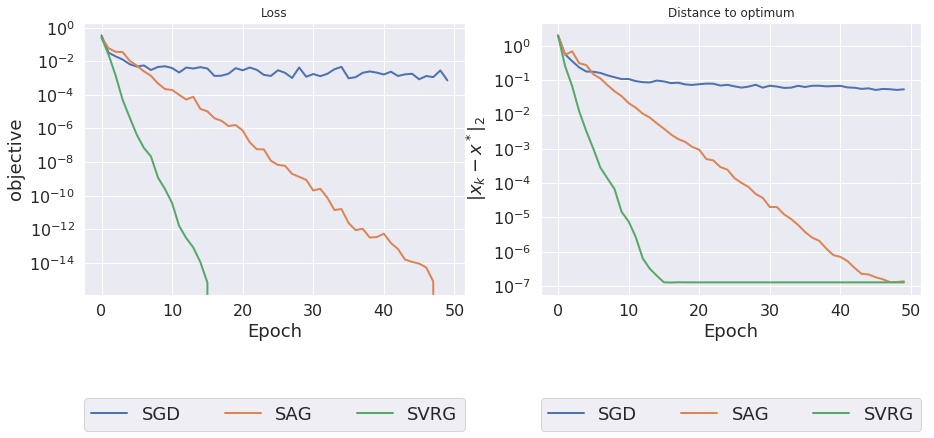

In [36]:
monitors = [monitor_sgd, monitor_sag,monitor_svrg]

solvers = ["SGD", "SAG","SVRG"]

plot_epochs(monitors, solvers)

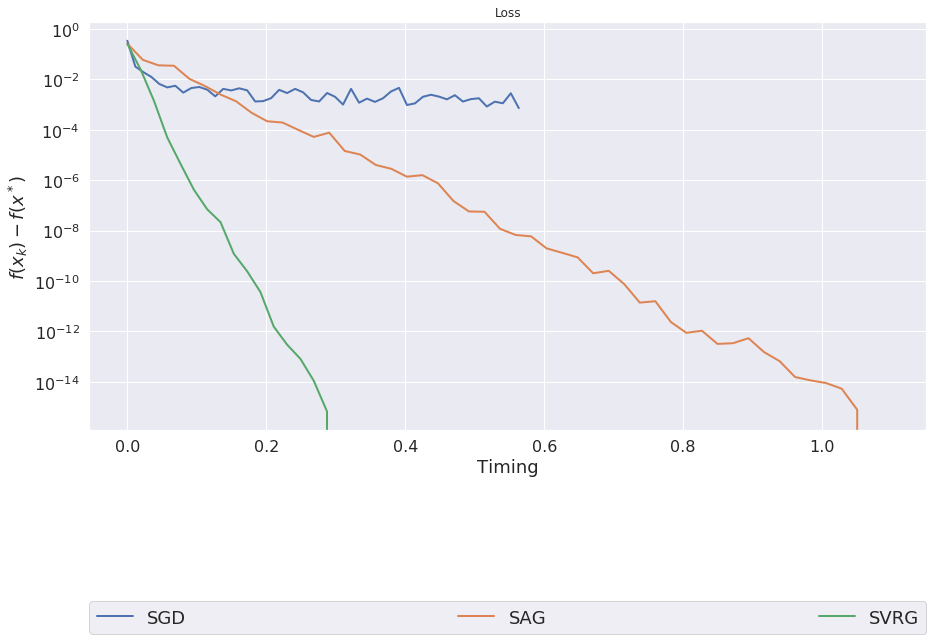

In [37]:
plot_time(monitors, solvers)

<a id='comp'></a> 
## 5. Numerical comparison

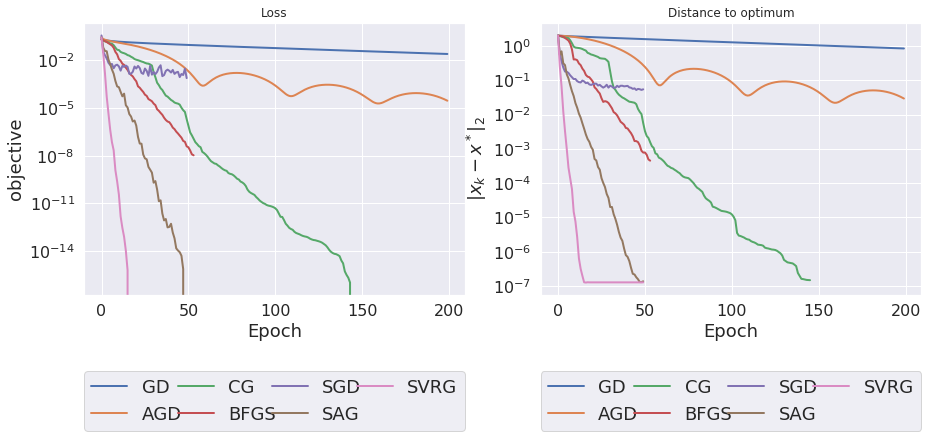

In [38]:
monitors = [monitor_gd, monitor_agd, monitor_cg, monitor_bfgs,
            monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["GD", "AGD", "CG", "BFGS", "SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

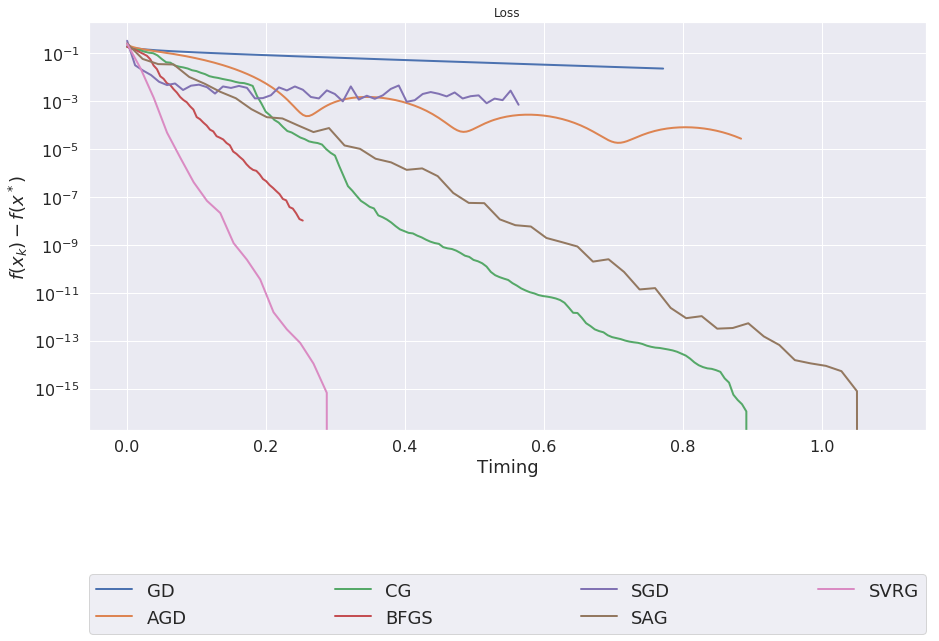

In [39]:
plot_time(monitors, solvers)

<a id='conc'></a>
## 6. Conclusion

*QUESTIONS*:
- Compare and comment your results
- Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1 / \sqrt n$ and compare your results. Comment.
- Play also with the level of correlation between features (parameter ``corr`` above), and compare results with low and high correlation.
- Conclude

<div class="alert alert-danger">
    <center> <h2> Comments about the results above </h2> </center>
    </div>

<div class="alert alert-info">

For batch methods :
* GD : We see here that it is the worst algorithm to use in this case ( High correlation, equal to 0.9 ).
* CG : At first, CG convergs slowly, then convergs fast. 
* AGD : AGD is faster than GD, but is altogether slow than BFGS and CG. 
* BFGS : BFGS is the fastest batch method, although it needs more time to converge entirely than CG.

--------------------------------------------

For stochastic methods :
* SGD : We can clearly see that this method's variance is quite high. Plus, it takes a long time to converge to the minimum comparing to other stochastic methods, but it is still perfoming better than GD.
* SAG : We can clearly see that this algorithm is faster than SGD. Although the fact that it's convergence is a bit slow, but also it's variance is quite high, it still convergs to the minimum.
* SVRG : This is the best from the 7 methods. This algorithm actually solves the problem of high variance. We can clearly observe that the graph of the SVRG method is far less fluctuating that the SAG and SGD ones.

-----------------------------

Conclusion :
* We can clearly see here, that the stochastic methods outperforms the batch methods in the linear regression case, with correlation equal to 0.9 as defined in the begening of the Lab. So, we need to study the effect of the regularization and the correlation, on both linear and logistic regression to be able to generalize these observations. 
</div>

<div class="alert alert-danger">
<center> <h2> Linear regression case : </h2> </center>
</div>

<div class="alert alert-info">
For this matter, we will define a function : 
</div>    

In [40]:
A, b = simu_linreg(x_model_truth, n, std=1., corr=0.4)

In [41]:
def plot_regul_cor(A,b,simu_model, x_model_truth, x_init, loss, grad, grad_i, n, lipschitz_model, lbda, corr_valeur, change_corr=False):
    
    if(change_corr):
          A, b = simu_model(x_model_truth, n, std=1., corr=corr_valeur)
    
    
    # Updating parameters :
    step_batch = 1. / lipschitz_model(A, b, lbda)
    max_squared_sum = np.max(np.sum(A ** 2, axis=1))
    step_stochastic = 1.0 / (max_squared_sum + lbda)
    x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A, b, lbda), pgtol=1e-30, factr=1e-30)
    
    #GD    
    monitor_gd = monitor(gd, loss, x_min, (A, b ,lbda))
    monitor_gd.run(x_init, grad, n_iter, step_batch, args=(A, b, lbda))

    #AGD
    monitor_agd = monitor(agd, loss, x_min, (A, b ,lbda))
    monitor_agd.run(x_init, grad, n_iter, step_batch, args=(A, b, lbda))

    #CG
    monitor_cg = monitor(scipy_runner(fmin_cg), loss, x_min, (A, b ,lbda))
    monitor_cg.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), gtol=1e-9)

    #L-BFGD
    monitor_bfgs = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min, (A, b ,lbda))
    monitor_bfgs.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), pgtol=1e-30)

    #SGD
    monitor_sgd = monitor(sgd, loss, x_min, (A, b ,lbda))
    monitor_sgd.run(x_init, iis, grad_i, n_iter * n, step0, args=(A, b, lbda))

    #SAG
    monitor_sag = monitor(sag, loss, x_min, (A, b ,lbda))
    monitor_sag.run(x_init, iis, grad_i, n_iter * n, step_stochastic, args=(A, b, lbda))

    #SVRG
    monitor_svrg = monitor(svrg, loss, x_min, (A, b ,lbda))
    monitor_svrg.run(x_init, iis, grad, grad_i, n_iter*n , step_stochastic, args=(A, b, lbda))

    #DRAW PLOTS

    monitors = [monitor_gd, monitor_agd, monitor_cg, monitor_bfgs,
                monitor_sgd, monitor_sag, monitor_svrg]

    solvers = ["GD", "AGD", "CG", "BFGS", "SGD", "SAG", "SVRG"]

    if(change_corr):
        plot_epochs(monitors, solvers, show_corr=True, corr = corr_valeur )
        plt.figure(figsize=(9,5))
        plot_time(monitors, solvers) 
    else:
        plot_epochs(monitors, solvers, show_lambda=True , lbda = lbda)
        plt.figure(figsize=(9,5))
        plot_time(monitors, solvers)

<div class="alert alert-info">
The penalization and the different correlations values, will be displayed on top of each figure. 
    </div>

<div class="alert alert-danger">
    <h3> Regularization parameter </h3>
</div>

<div class="alert alert-danger">
    <h4> High penalisation : For $ \lambda = \frac{1}{n}$ </h4>
  </div>

         Current function value: 0.492781
         Iterations: 27
         Function evaluations: 41
         Gradient evaluations: 40


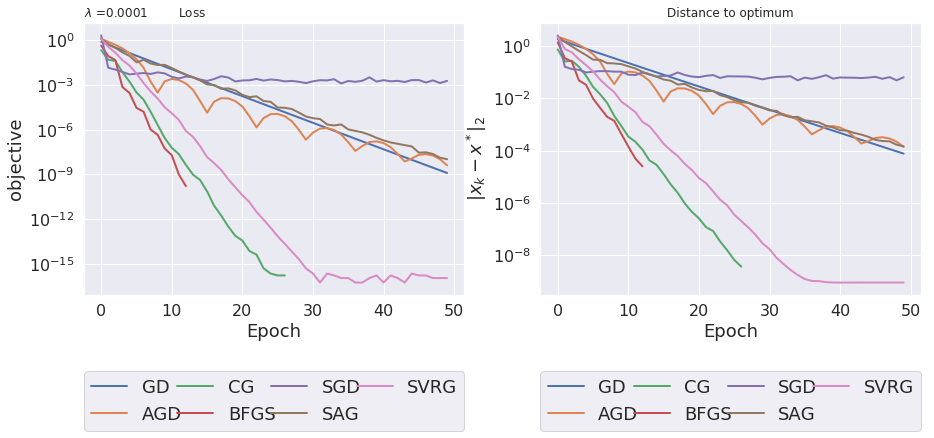

<Figure size 648x360 with 0 Axes>

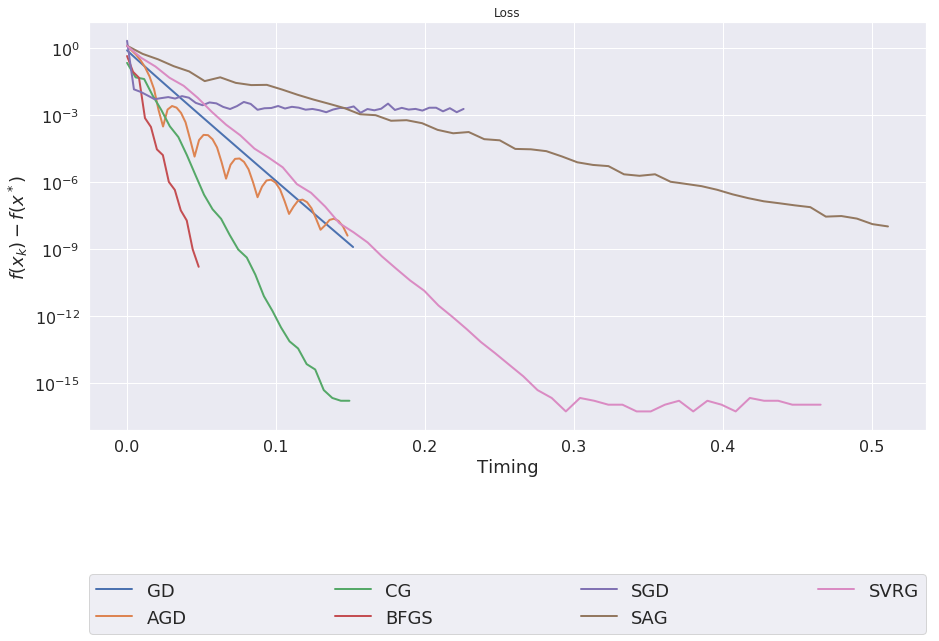

In [42]:
plot_regul_cor(A,b,simu_linreg,x_model_truth,x_init,loss,grad,grad_i, n, lipschitz_linreg ,lbda=1. / n, corr_valeur = 0.4  )

<div class="alert alert-danger">
<h4> Low penalisation : For $ \lambda = \frac{1}{\sqrt{n}}$ </h4>
</div>

         Current function value: 0.519158
         Iterations: 26
         Function evaluations: 83
         Gradient evaluations: 71


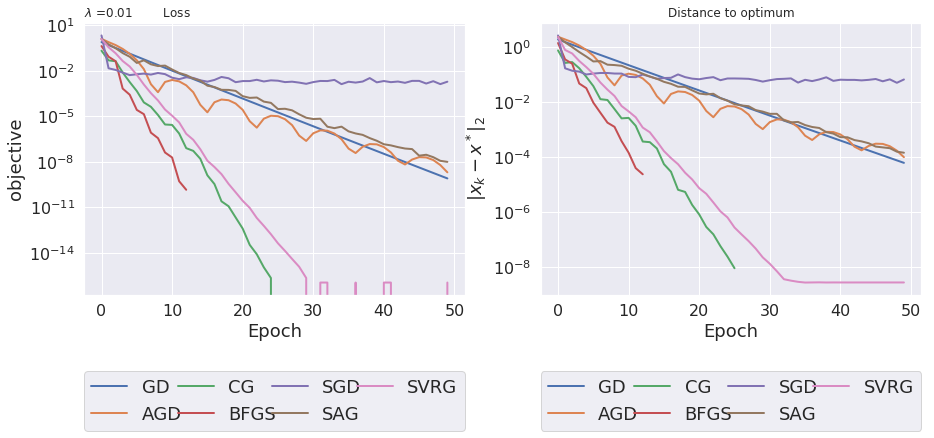

<Figure size 648x360 with 0 Axes>

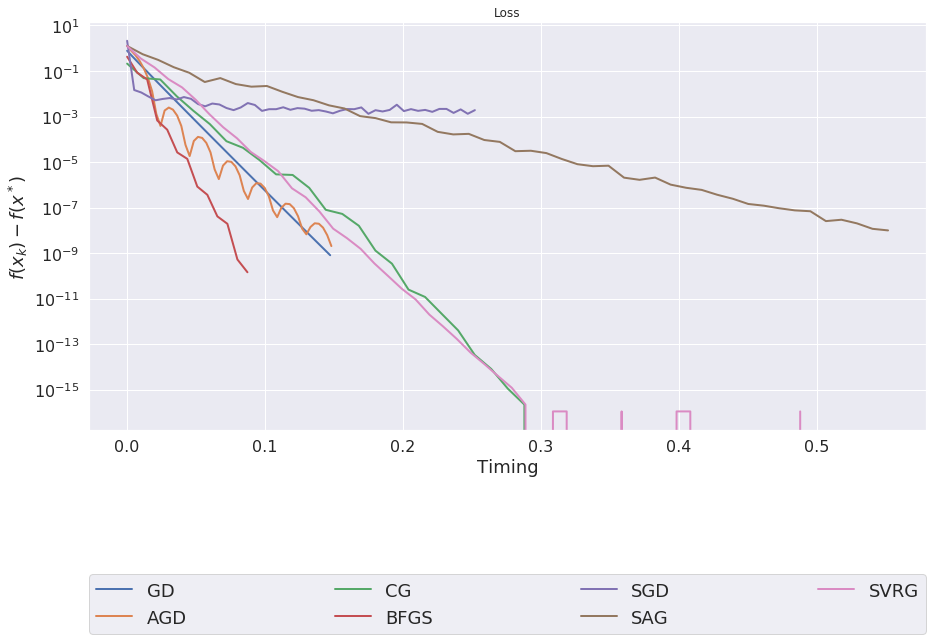

In [43]:
plot_regul_cor(A,b,simu_linreg,x_model_truth,x_init,loss,grad,grad_i, n, lipschitz_linreg ,lbda=1./n**(0.5) , corr_valeur = 0.4  )

<div class="alert alert-danger">
    <h3>Feature correlation parameter</h3>
 </div>

The correlation value is equal to 0.1
Optimization terminated successfully.
         Current function value: 0.540290
         Iterations: 14
         Function evaluations: 17
         Gradient evaluations: 17
The correlation value is equal to 0.3
         Current function value: 0.527424
         Iterations: 21
         Function evaluations: 95
         Gradient evaluations: 83
The correlation value is equal to 0.7
         Current function value: 0.517820
         Iterations: 50
         Function evaluations: 87
         Gradient evaluations: 87
The correlation value is equal to 0.9
         Current function value: 0.524311
         Iterations: 50
         Function evaluations: 83
         Gradient evaluations: 83


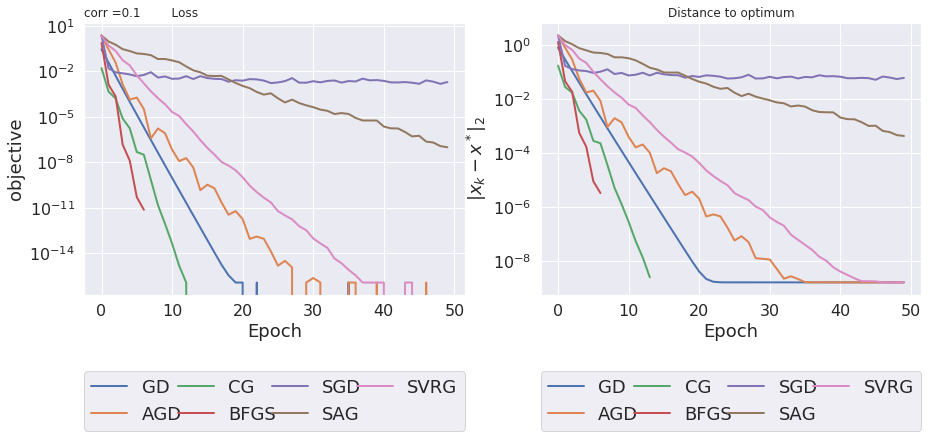

<Figure size 648x360 with 0 Axes>

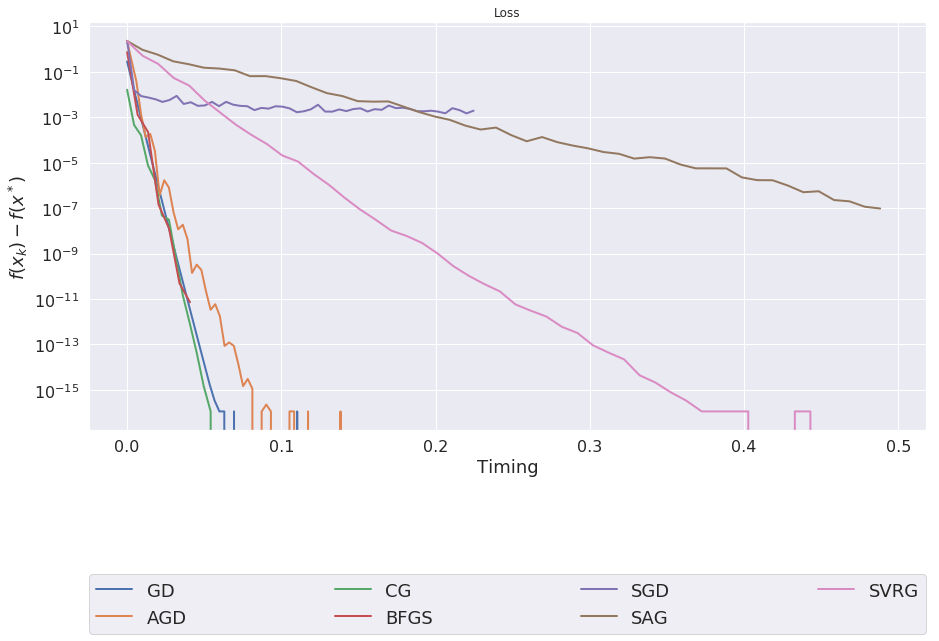

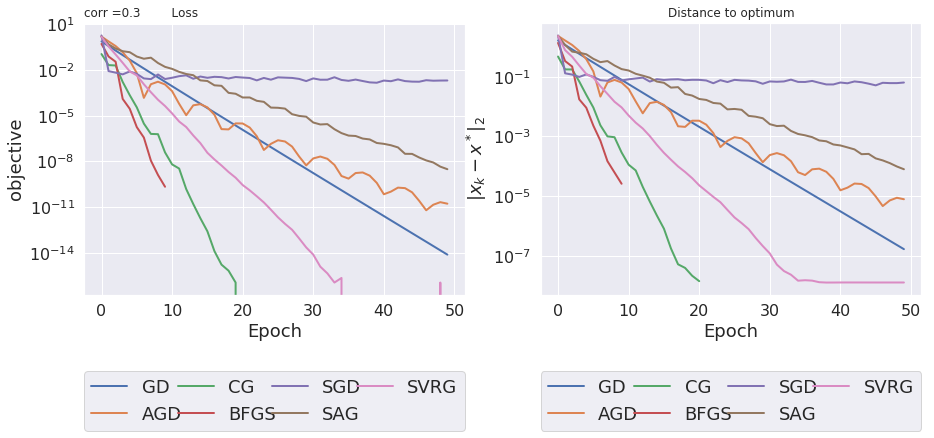

<Figure size 648x360 with 0 Axes>

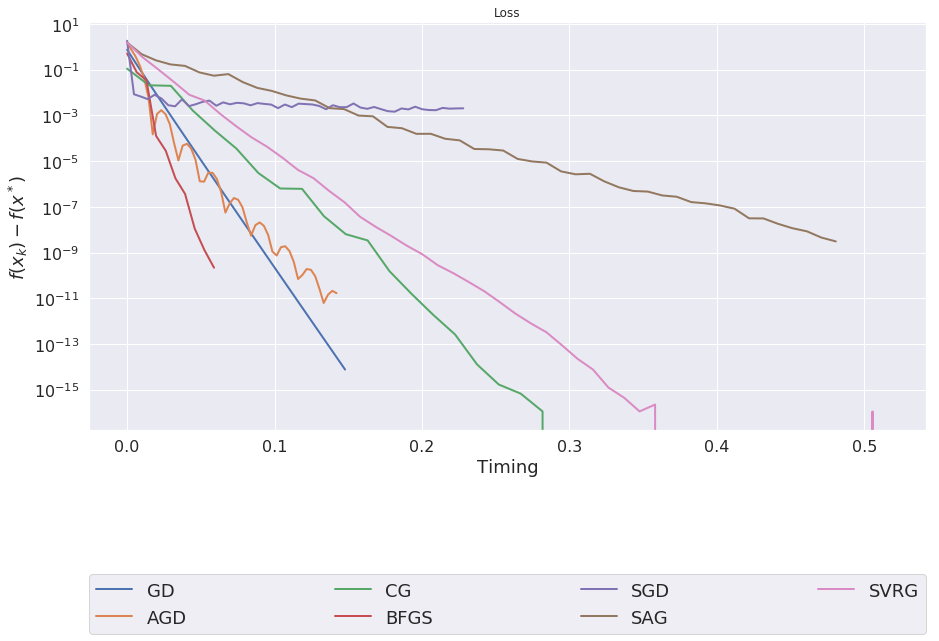

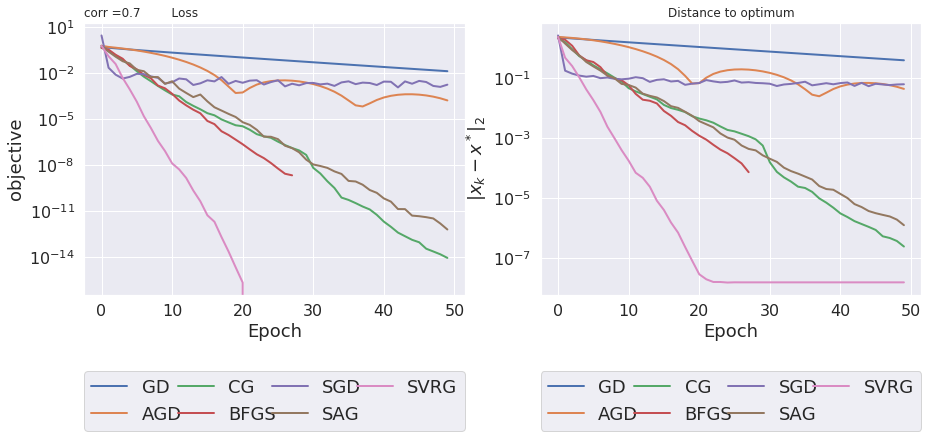

<Figure size 648x360 with 0 Axes>

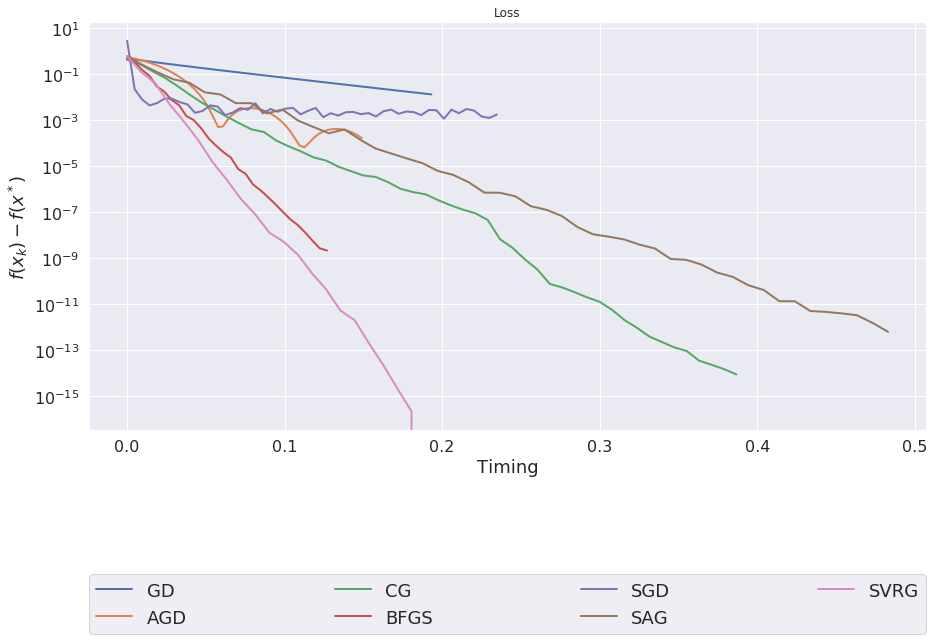

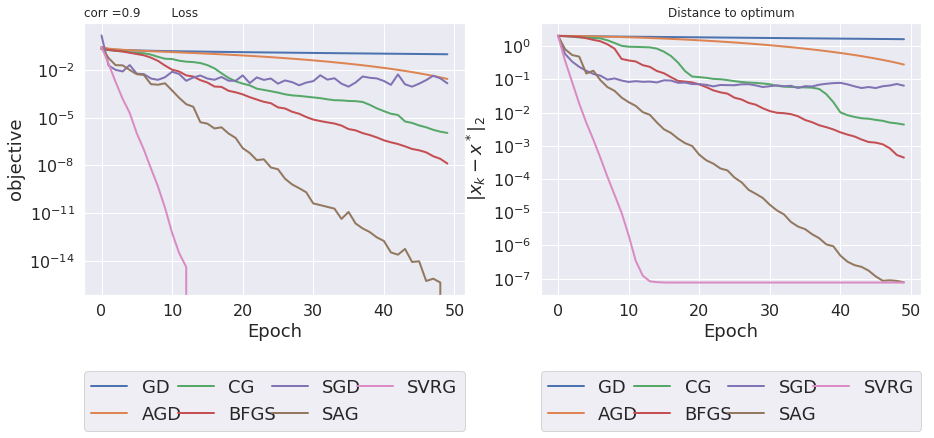

<Figure size 648x360 with 0 Axes>

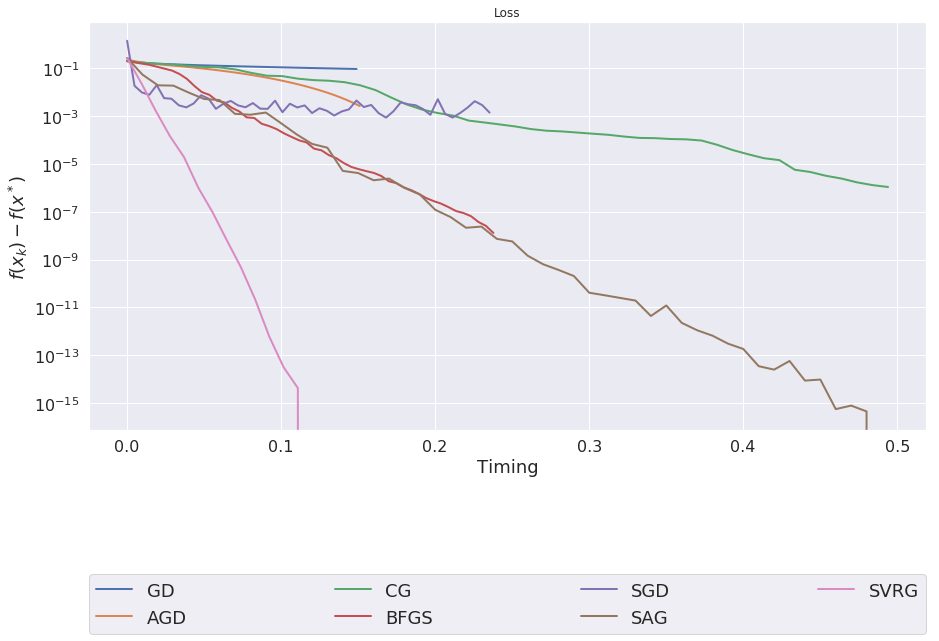

In [44]:
corr_list=[0.1, 0.3, 0.7, 0.9]

for cor in corr_list:
    
    print('The correlation value is equal to ' + str(cor))
    plot_regul_cor(A,b,simu_linreg,x_model_truth,x_init,loss,grad,grad_i, n, lipschitz_linreg ,lbda=1./n**(0.5) ,corr_valeur=cor, change_corr=True)

<div class="alert alert-danger">
    <h3> Comments about linear regression :  </h3>
    </div>

<div class="alert alert-info">

About the regularization :
* For $ \lambda = \frac{1}{\sqrt{n}}$ and  $ \lambda = \frac{1}{n}$ We don't see much of a difference between the graphs, but only in the convergence time, where convergence time for most algorithm is practicly divided by 2 for lower regularization for some algorithm like CG. 

---------------------------------

About correlation :
* By changing the correlation value, we can see that whenever the correlation is low, the batch methods [BFGS, CG and AGD] perform very well comparing to the stochastic methods, except for SVRG who's still have a bit of similar results. 

* But then, when the correlation value increases, SVRG becomes the best method to use. We can clearly see that whenever we increase the value of correlation, the performance of batch methods gets worse. SVRG and SAG methods become the best methods to implement. We can also see, that BFGS is a bit similar to SAG, the only problem that it needs more time to get to it's minimum. 

----------------------------------

Conclusion :

* For linear regression, before applying any solver, we should do some pre-processing on the data, to see if we have high correlation or not, and so, know the solver we will be using. ( The regularization, has practicly no effect on the solvers except for CG which time of convergence is halfed ).

</div>

-----------------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------------

<div class="alert alert-danger">
<center> <h2> Logistic regression case :  </h2> </center>
 </div>

In [45]:
A_log, b_log = simu_logreg(x_model_truth, n, std=1., corr=0.4)
loss_log = loss_logreg
grad_log = grad_logreg
grad_i_log = grad_i_logreg

<div class="alert alert-danger">
<h3> Regularization parameter </h3>
    </div>

<div class="alert alert-danger">

<h4> High penalisation : For $ \lambda = \frac{1}{n}$ </h4>

</div>

         Current function value: 0.377390
         Iterations: 34
         Function evaluations: 153
         Gradient evaluations: 141


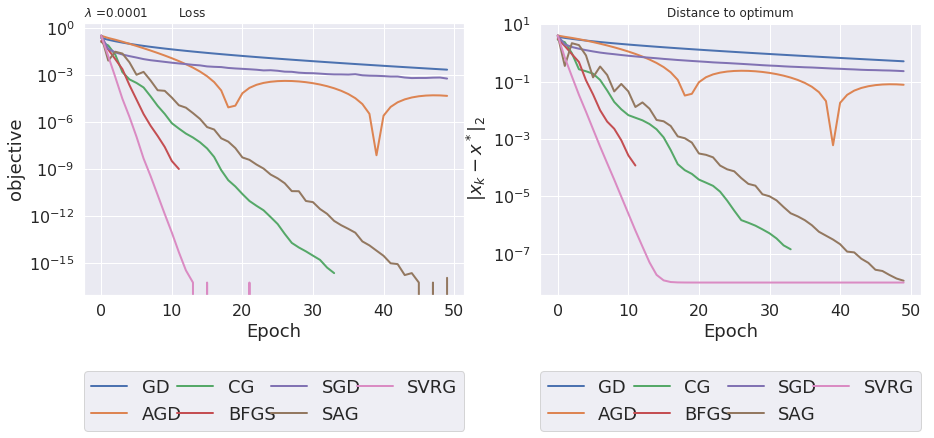

<Figure size 648x360 with 0 Axes>

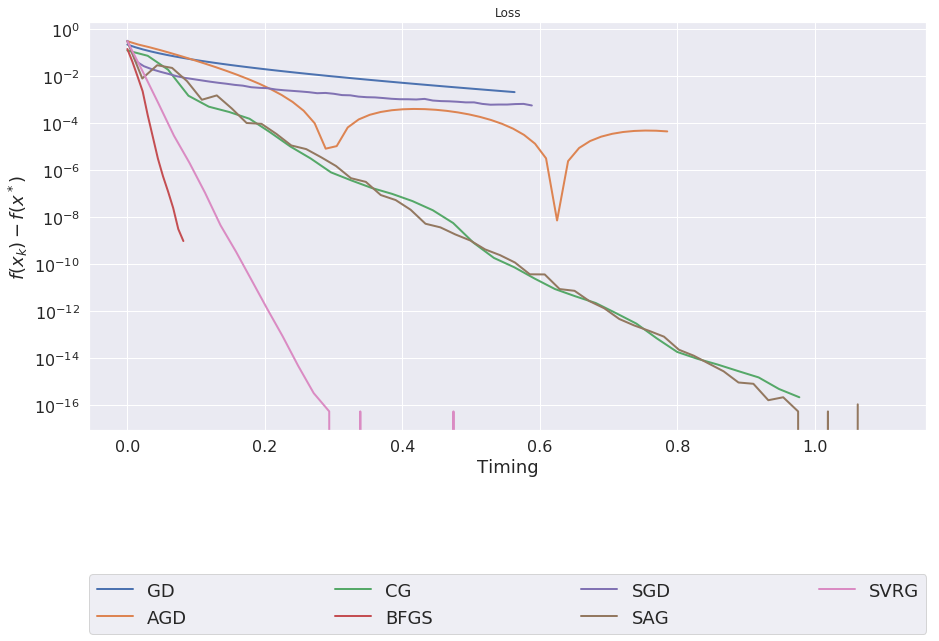

In [46]:
plot_regul_cor(A_log, b_log, simu_logreg, x_model_truth, x_init, loss_log, grad_log, grad_i_log, n, lipschitz_logreg ,lbda=1. / n, corr_valeur = 0.4  )

<div class="alert alert-danger">
    <h4> Low penalisation : For $ \lambda = \frac{1}{\sqrt{n}}$ </h4>
    </div>

Optimization terminated successfully.
         Current function value: 0.431953
         Iterations: 27
         Function evaluations: 61
         Gradient evaluations: 61


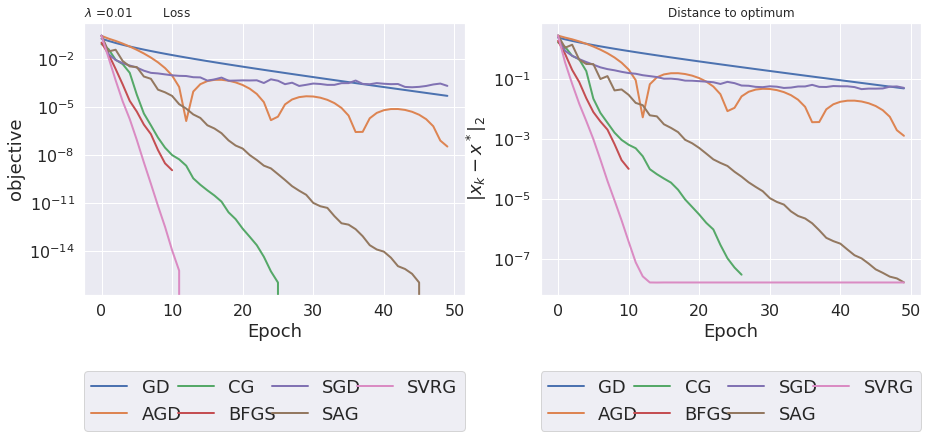

<Figure size 648x360 with 0 Axes>

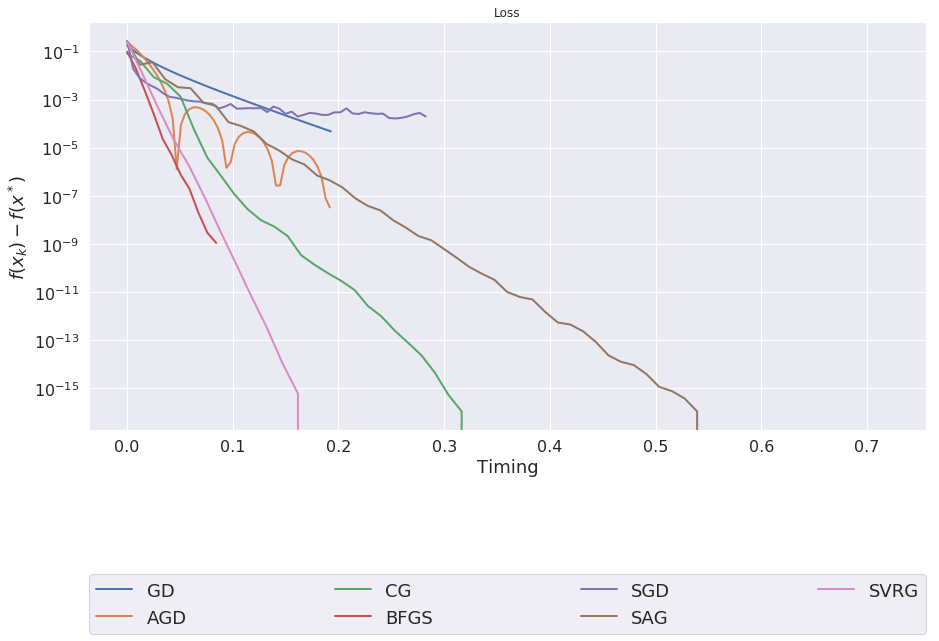

In [47]:
plot_regul_cor(A_log, b_log, simu_logreg, x_model_truth, x_init, loss_log, grad_log, grad_i_log, n, lipschitz_logreg ,lbda=1./n**(0.5) , corr_valeur = 0.4  )

<div class="alert alert-danger">
    <h3> Feature correlation parameter </h3>
    </div>
    

The correlation value is equal to 0.1
Optimization terminated successfully.
         Current function value: 0.357461
         Iterations: 19
         Function evaluations: 50
         Gradient evaluations: 50
The correlation value is equal to 0.3
Optimization terminated successfully.
         Current function value: 0.410404
         Iterations: 28
         Function evaluations: 69
         Gradient evaluations: 69
The correlation value is equal to 0.7
         Current function value: 0.523734
         Iterations: 49
         Function evaluations: 105
         Gradient evaluations: 104
The correlation value is equal to 0.9
         Current function value: 0.599781
         Iterations: 50
         Function evaluations: 72
         Gradient evaluations: 72


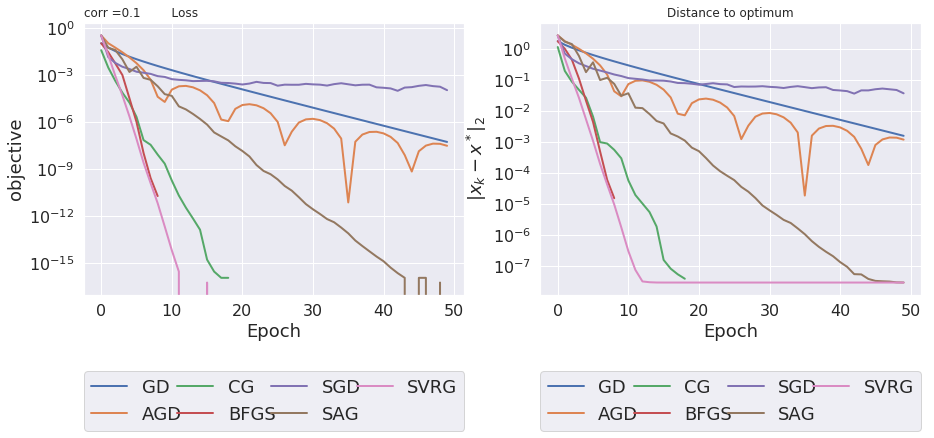

<Figure size 648x360 with 0 Axes>

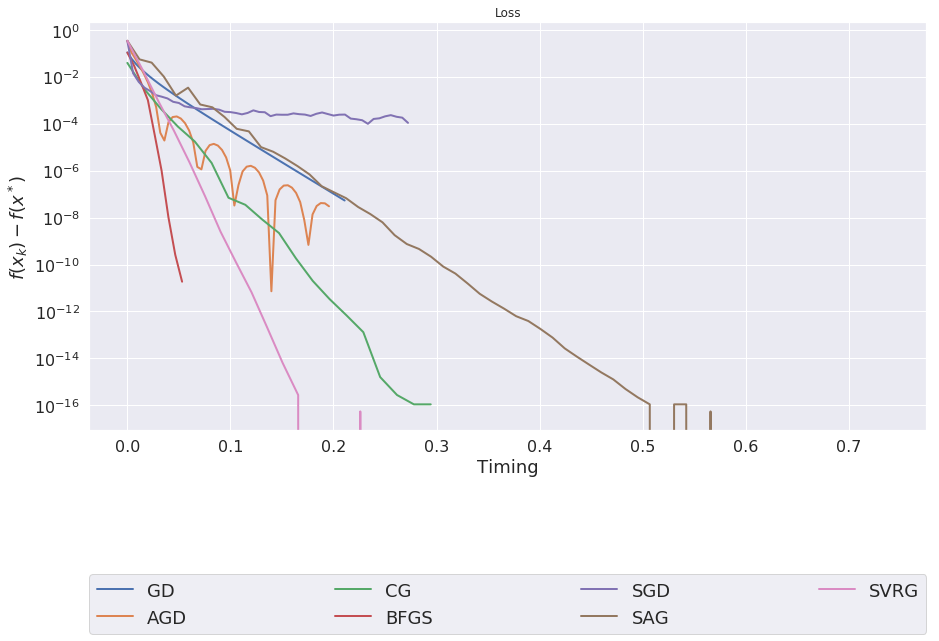

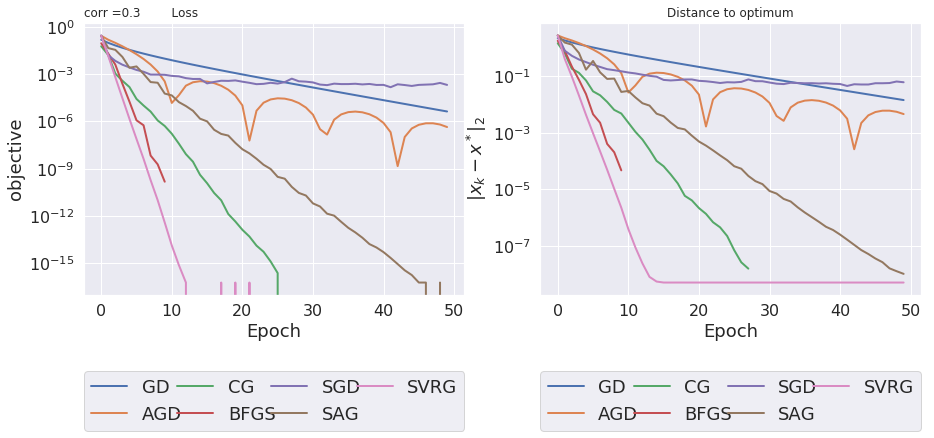

<Figure size 648x360 with 0 Axes>

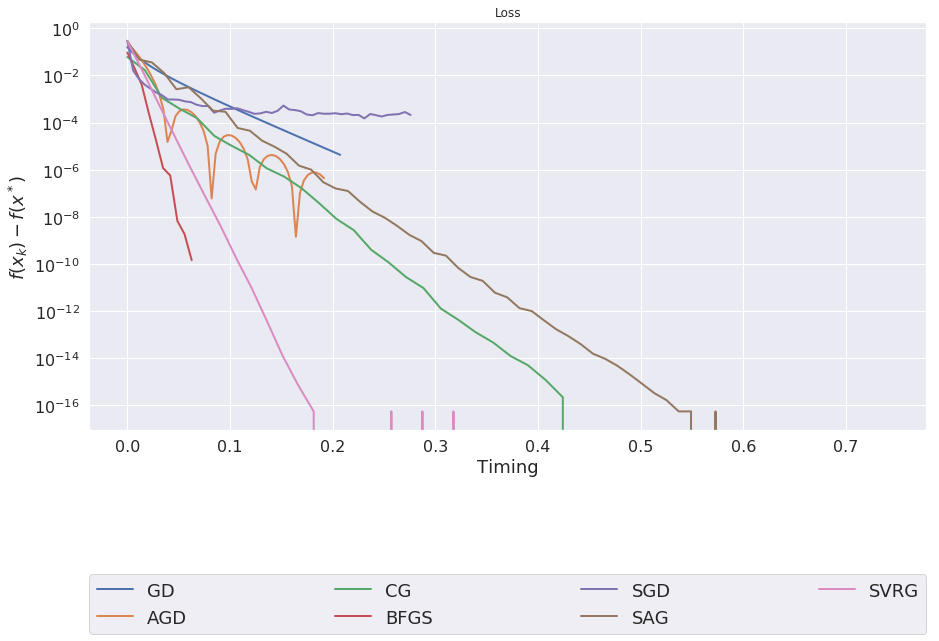

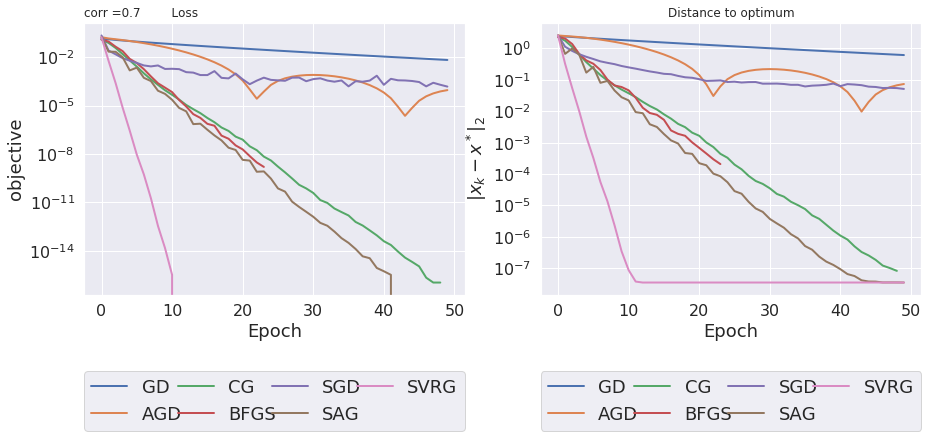

<Figure size 648x360 with 0 Axes>

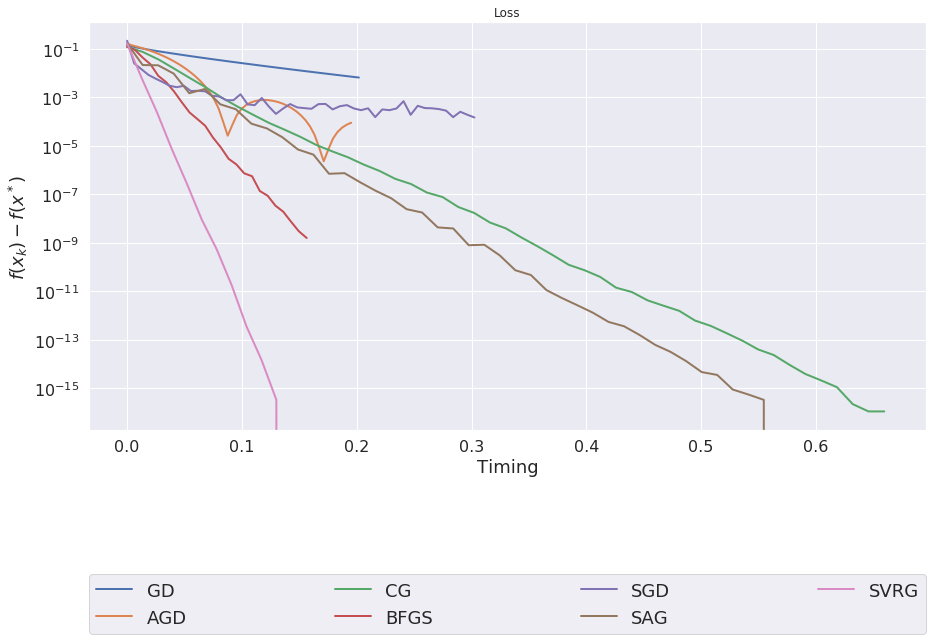

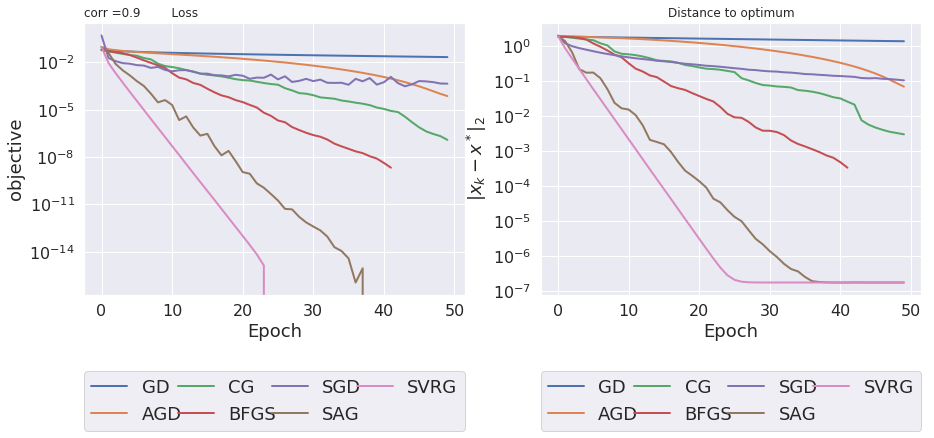

<Figure size 648x360 with 0 Axes>

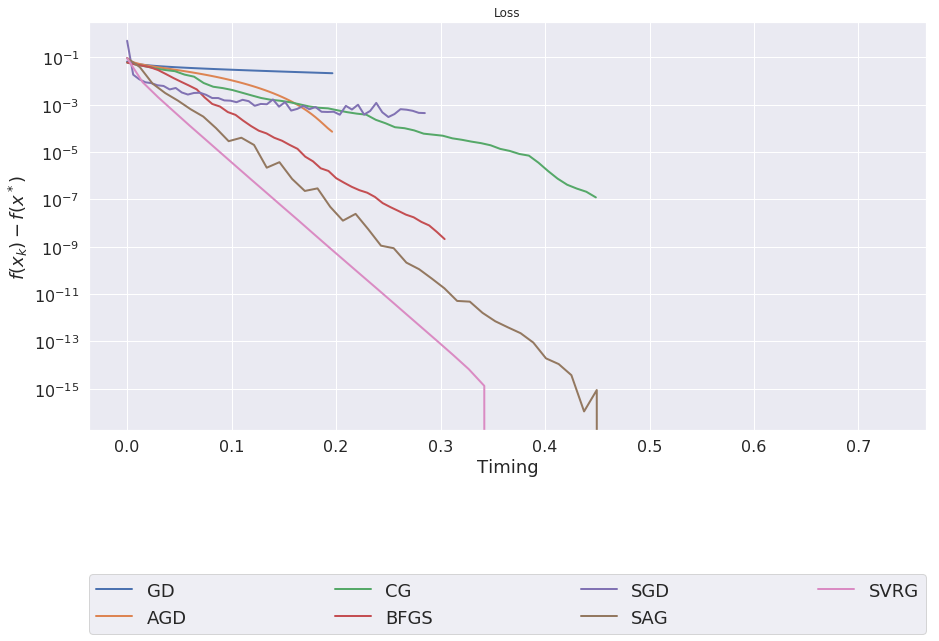

In [48]:
corr_list=[0.1, 0.3, 0.7, 0.9]

for cor in corr_list:
    
    print('The correlation value is equal to ' + str(cor))
    plot_regul_cor(A_log, b_log, simu_logreg, x_model_truth, x_init, loss_log, grad_log, grad_i_log, n, lipschitz_logreg ,lbda=1./n**(0.5), corr_valeur = cor , change_corr=True  )

<div class="alert alert-danger">
<h3>Comments about logistic regression : </h3>
</div>

<div class="alert alert-info">

About the regularization :
* For $ \lambda = \frac{1}{\sqrt{n}}$ and  $ \lambda = \frac{1}{n}$ , here we do not see also much of a difference between them. The only slight difference is that the time of convergence of some methods such as SAG ( Who passed from 1.1 seconds in high penalization to 0.6 seconds in low penalization, and also for CG who passed from 0.4 seconds in high penalization  to 0.2 seconds in low penalization. 

----------------------------------------

About correlation :
* When the correlation was low, we see that batch methods are working quite well with a good speed of convergence. The difference here comparing to the linear regression, is that SVRG have quite a good speed of convergence with low correlation. 

* We can clearly see, that whenever we increase the correlation, batch methods gets from worse to worst, and the best method remains SVRG for logistic regression with high correlation. 

---------------------------------

Conclusion :

* SVRG, is by far, the best solver for logistic regression, wether we have a low/high correlation. The only problem that it comes with a great computational cost. 

</div>

<div class="alert alert-danger">
<center> <h2> General conclusion </h2> </center>
</div>

<div class="alert alert-info">
To sum up, we can say that the level of ridge penalization does not affect that much the solvers we are using. On the other hand, the correlation plays an important role in choosing the method we will be using.
    
-----------------------------
For low correlation, batch solvers are prefered than the stochastic solvers especially CG and BFGS like explained on the first part of this lab. On the other hand, when the correlation is quite high, stochastic solvers are the one prefered, especially SVRG which performance is very impressive according the graphs that we got on this lab, the only problem with SVRG are mainly computational problems.
</div>